In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
import os
import glob
import re
import sys
import pickle

from ipywidgets import interact, Dropdown

from photutils.aperture import CircularAperture, aperture_photometry
from spectral_cube import SpectralCube

from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from astropy.wcs import WCS
from astropy.constants import c
from astropy.io import fits
from astropy.visualization import simple_norm, imshow_norm
from astropy.visualization import AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch
from matplotlib.patches import Circle, Rectangle
from matplotlib.gridspec import GridSpec
from astropy.nddata import block_reduce
from astropy.nddata import Cutout2D

home_directory = "/d/ret1/Taylor/jupyter_notebooks/Research" 
os.chdir(home_directory) #TJ change working directory to be the parent directory

from Py_files.Basic_analysis import * #TJ import basic functions from custom package
from Py_files.Convolution_script import * #TJ import convolution functions from custom package
from Py_files.All_flux_calibration_functions import *
with open("Data_files/misc_data/jwst_pivots.pkl", "rb") as file:
    jwst_pivots = pickle.load(file)
with open("Data_files/misc_data/jwst_filter_means.pkl", "rb") as file:
    jwst_means = pickle.load(file)

image_files, filter_files = generate_list_of_files()
v0p3_images, _ = generate_v0p3_files()
full_raw_ifu_files_loc0 = ['Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g395m-f290lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch1-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch2-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch3-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch4-shortmediumlong_s3d.fits']
full_raw_ifu_files_loc1 = ['Data_files/IFU_files/raw_IFUs/location_1/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_1/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_1/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_1/Arm2_Level3_ch1-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_1/Arm2_Level3_ch2-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_1/Arm2_Level3_ch3-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_1/Arm2_Level3_ch4-shortmediumlong_s3d.fits']
full_raw_ifu_files_loc3 = ['Data_files/IFU_files/raw_IFUs/location_3/jw03435-o006_t010_nirspec_g140m-f100lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_3/jw03435-o006_t010_nirspec_g235m-f170lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_3/jw03435-o006_t010_nirspec_g395m-f290lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_3/Arm3_Level3_ch1-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_3/Arm3_Level3_ch2-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_3/Arm3_Level3_ch3-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_3/Arm3_Level3_ch4-shortmediumlong_s3d.fits']
#TJ this full_spectrum is built by stitching cube0 to cube1 anchored to cube1
#TJ then stitching cube2 to cube3 anchored to cube3, then stitching all the others unaltered
full_spec = 'Data_files/misc_data/Updated_flux_calibration/full_spectrum_loc0_rad1p25.npy'
locations = [[202.5062429, 47.2143358], [202.4335225, 47.1729608], [202.4340450, 47.1732517], [202.4823742, 47.1958589]]
radius = 1.25*u.arcsec

#TJ load the additive offset data

loc0_datasets = []
files = glob.glob('Data_files/IFU_files/calibrated_IFUs/location_0/g*')
for file in files:
    data = np.load(file)
    loc0_datasets.append(data)
    
loc1_datasets = []
files = glob.glob('Data_files/IFU_files/calibrated_IFUs/location_1/g*')
for file in files:
    data = np.load(file)
    loc1_datasets.append(data)
    
loc2_datasets = []
files = glob.glob('Data_files/IFU_files/calibrated_IFUs/location_2/g*')
for file in files:
    data = np.load(file)
    loc2_datasets.append(data)

loc3_datasets = []
files = glob.glob('Data_files/IFU_files/calibrated_IFUs/location_3/g*')
for file in files:
    data = np.load(file)
    loc3_datasets.append(data)
    
#TJ load the multiplicative data
loc0_m_datasets = []
files = glob.glob('Data_files/IFU_files/calibrated_IFUs/location_0/m*')
for file in files:
    data = np.load(file)
    loc0_m_datasets.append(data)
    
loc1_m_datasets = []
files = glob.glob('Data_files/IFU_files/calibrated_IFUs/location_1/m*')
for file in files:
    data = np.load(file)
    loc1_m_datasets.append(data)
    
loc2_m_datasets = []
files = glob.glob('Data_files/IFU_files/calibrated_IFUs/location_2/m*')
for file in files:
    data = np.load(file)
loc2_m_datasets.append(data)

loc3_m_datasets = []
files = glob.glob('Data_files/IFU_files/calibrated_IFUs/location_3/m*')
for file in files:
    data = np.load(file)
    loc3_m_datasets.append(data)

In [71]:
def is_filter_relevent(filter, ifu_file):
    '''If a filter's mean wavelength is inside the ifu, returns True
    -------------
    
    Parameters
    -------------
    filter : type = string - name of filter ("F115W")
    ifu_file : type = string - string to location of ifu file
    
    Returns
    -------------
    True if filter's mean wavelength is inside the ifu_file, False if it is not.
    '''
    wls = SpectralCube.read(ifu_file, hdu = 'SCI').spectral_axis.to(u.m)
    short, long = wls[0], wls[-1]
    return (jwst_means[filter] > short) & (jwst_means[filter] < long)
    
def adjust_spectrum(original_ifu, filter_name, image_files, location, radius, adjustment_operation = 'add'):
    '''Takes an ifu file and adjusts the flux through an aperture centered at a location with specified radius.
    -------------
    
    Parameters
    -------------
    original_ifu : type = string (or, see retry=True)- string to location of ifu file
    filter_name : type = string - filter name like "F115W"
    location : type = either SkyCoord or list of [ra, dec] values in degrees - location of center of aperture
    radius : type = angular size - radius of aperture, must have units attached.
    adjustment_operation (optional, defaults to 'add'): type = string - either 'add' or 'multiply' to specify what kind of correction to use
    
    Returns
    -------------
    Structured Numpy array with 'intensity' and 'wavelength' keys
    '''
    if filter_name is None:
        return get_IFU_spectrum(original_ifu, location, radius, replace_negatives = False), 0
    else:
        image_file = [x for x in image_files if extract_filter_name(x)==filter_name][0]
        raw_data = get_IFU_spectrum(original_ifu, location, radius, replace_negatives = False)
        filter_wl, filter_trans = get_filter_data(filter_name) #TJ this is the transmission vs wavelength function for this filter
        image_flux = get_image_flux(image_file, location, radius, replace_negatives = False) #TJ this is the flux we SHOULD get
        initial_synth_flux = get_Fnu_transmission(raw_data['intensity'], raw_data['wavelength'], filter_trans, filter_wl, warnings = True) #TJ this is the current synthetic flux we get
        if adjustment_operation == 'add':
            correction = image_flux - initial_synth_flux
            raw_data['intensity'] = raw_data['intensity'] + correction
            return raw_data, correction #TJ now corrected to match photometry
        elif adjustment_operation == 'multiply':
            correction = image_flux/initial_synth_flux
            raw_data['intensity'] = raw_data['intensity']*correction
            return raw_data, correction #TJ now corrected
        else:
            print('adjustment operation not recognized, only "add" or "multiply" are currently implemented')
            return None
        print('Something went wrong.')
        return raw_data, correction#TJ Now corrected data


def get_largest_filter_within(ifu_file):
    '''Takes an ifu file and selects the filter with the largest bandpass that is entirely within it.
    -------------
    
    Parameters
    -------------
    ifu_file : type = string - string to location of ifu file
    
    Returns
    -------------
    Filter name (ex. "F115W") corresponding to the largest filter entirely contained within the IFU file 
    '''
    filters = [extract_filter_name(x) for x in filter_files if full_coverage(extract_filter_name(x),ifu_file)=="good"]
    if len(filters)<1:
        print(f'No filters entirely within {ifu_file}')
        return None
    else:
        best_filter = filters[np.argmax([(get_filter_wl_range(fil)[1].value - get_filter_wl_range(fil)[0].value) for fil in filters])]
        return best_filter

def needed_datasets(filter_name, datasets):
    '''returns which ifu_files should be considered when calculating the synthetic flux. If an ifu even slightly overlaps into
    the filter's range it is included.
    -------------
    
    Parameters
    -------------
    filter : type = string - name of filter ("F115W")
    datasets : type = structured array - array with keys for 'wavelength' and 'intensity'
    
    Returns
    -------------
    Filter name (ex. "F115W") corresponding to the largest filter entirely contained within the IFU file 
    '''
    needed = []
    filter_wl, _ = get_filter_data(filter_name)
    for data in datasets:
        if (filter_wl[0] < data['wavelength'][-1]) & (filter_wl[-1] > data['wavelength'][0]):
            needed.append(data)
    return needed

def merge_datasets(ds1, ds2):
    """
    Merge two structured arrays with 'wavelength' and 'intensity' keys.
    Handles overlapping regions by averaging intensities, and automatically
    determines which dataset has higher wavelength resolution.
    """
    # Sort by wavelength, just to be safe
    ds1 = np.sort(ds1, order='wavelength')
    ds2 = np.sort(ds2, order='wavelength')

    # Determine wavelength resolutions
    d1_res = np.mean(np.diff(ds1['wavelength']))
    d2_res = np.mean(np.diff(ds2['wavelength']))

    # Assign high- and low-resolution datasets
    if d1_res < d2_res:
        highres, lowres = ds1, ds2
    else:
        highres, lowres = ds2, ds1

    # Determine overlap region
    overlap_start = max(highres['wavelength'][0], lowres['wavelength'][0])
    overlap_end   = min(highres['wavelength'][-1], lowres['wavelength'][-1])

    # Interpolate the lowres data onto highres wavelengths (only inside overlap)
    overlap_mask = (highres['wavelength'] >= overlap_start) & (highres['wavelength'] <= overlap_end)
    interp_flux = np.interp(highres['wavelength'][overlap_mask],
                            lowres['wavelength'], lowres['intensity'])

    # Combine in overlap by averaging
    merged_overlap_wl = highres['wavelength'][overlap_mask]
    merged_overlap_intensity = 0.5 * (highres['intensity'][overlap_mask] + interp_flux)

    # Keep the unique non-overlapping parts from both sides
    full_low_side  = ds1[ds1['wavelength'] < overlap_start]
    full_high_side = ds2[ds2['wavelength'] > overlap_end]

    # Concatenate all pieces and sort
    merged = np.concatenate([
        full_low_side,
        np.rec.fromarrays([merged_overlap_wl, merged_overlap_intensity],
                          names=('wavelength', 'intensity')),
        full_high_side
    ])
    merged = np.sort(merged, order='wavelength')

    return merged


def get_all_fluxes(filter_files, spec_datasets, image_files, location, radius):
    '''Creates synthetic fluxes for all filters in the files that have wavelengths that span the entire filter.
    For filters that straddle multiple wavelengths, any wavelength inside a filter that has intensity values
    from multiple datasets uses the average intensity from each dataset.
    -------------
    
    Parameters
    -------------
    filter_files : type = list of strings - name of filter ["F115W", "F2100W"]
    datasets : type = list of structured arrays - arrays with keys for 'wavelength' and 'intensity'
    image_files : type = list of strings - strings to image files
    location : type = either SkyCoord or list of [ra, dec] values in degrees - location of center of aperture
    radius : type = angular size - radius of aperture, must have units attached.
    
    Returns
    -------------
    A dictionary with keys for 'filter_name', 'mean_wl', 'synth_flux', and 'photo_flux'
    '''
    results = {}

    results['filter_name'] = []
    results['mean_wl'] = []
    results['synth_flux'] = []
    results['photo_flux'] = []
    results['wavelength'] = []
    results['intensity'] = []
    
    for i, data in enumerate(spec_datasets[1:]):
        if i == 0:
            prior_data = spec_datasets[0]
        prior_data = merge_datasets(prior_data, data)
        
    results['wavelength'].append(prior_data['wavelength'])
    results['intensity'].append(prior_data['intensity'])
    
    
    for filter_file in filter_files:
        filter_name = extract_filter_name(filter_file)
        image_file = [x for x in image_files if extract_filter_name(x)==filter_name][0]
        photo_flux = get_image_flux(image_file, location, radius, replace_negatives = False)
        results['photo_flux'].append(photo_flux)
        filter_wl, filter_trans = get_filter_data(filter_name)
        results['filter_name'].append(filter_name)
        results['mean_wl'].append(jwst_means[filter_name].value)
        needed_data = needed_datasets(filter_name, spec_datasets)
        if len(needed_data) == 0:
            print('no spectral data was found for ', filter_name)
        if len(needed_data)<2:
            synth_flux = get_Fnu_transmission(needed_data[0]['intensity'], needed_data[0]['wavelength'], filter_trans, filter_wl, warnings = True)
            results['synth_flux'].append(synth_flux)
            
        else:
            full_data = merge_datasets(needed_data[0], needed_data[1])
            synth_flux = get_Fnu_transmission(full_data['intensity'], full_data['wavelength'], filter_trans, filter_wl, warnings = True)
            results['synth_flux'].append(synth_flux)
    results['wavelength'] = np.array(results['wavelength'][0])
    results['intensity'] = np.array(results['intensity'][0])
    results['filter_name'] = np.array(results['filter_name'])
    results['mean_wl'] = np.array(results['mean_wl'])
    results['synth_flux'] = np.array(results['synth_flux'])
    results['photo_flux'] = np.array(results['photo_flux'])
    return results


def get_overlap_region(ds1, ds2):
    """
    Return only the overlapping wavelength region between two structured arrays
    with 'wavelength' and 'intensity'. The returned region contains:
        - wavelength grid from the higher-resolution dataset (within overlap)
        - intensity = average(intensity_highres, interpolated_intensity_lowres)
    """

    # Sort to ensure order
    ds1 = np.sort(ds1, order='wavelength')
    ds2 = np.sort(ds2, order='wavelength')

    # Compute wavelength resolutions
    d1_res = np.mean(np.diff(ds1['wavelength']))
    d2_res = np.mean(np.diff(ds2['wavelength']))

    # Identify high- and low-resolution datasets
    if d1_res < d2_res:
        highres, lowres = ds1, ds2
    else:
        highres, lowres = ds2, ds1

    # Determine numerical overlap bounds
    overlap_start = max(highres['wavelength'][0], lowres['wavelength'][0])
    overlap_end   = min(highres['wavelength'][-1], lowres['wavelength'][-1])

    # If no overlap, return empty structured array
    if overlap_start >= overlap_end:
        return np.recarray(0, dtype=[('wavelength', float), ('intensity', float)])

    # Mask for high-res wavelengths inside the overlap
    mask = (highres['wavelength'] >= overlap_start) & (highres['wavelength'] <= overlap_end)

    high_wl = highres['wavelength'][mask]
    high_flux = highres['intensity'][mask]

    # Interpolate lowres intensities onto the highres wavelength grid
    interp_flux = np.interp(high_wl,
                            lowres['wavelength'],
                            lowres['intensity'])

    # Average intensities
    avg_flux = 0.5 * (high_flux + interp_flux)

    # Return structured array
    overlap = np.rec.fromarrays(
        [high_wl, avg_flux],
        names=('wavelength', 'intensity')
    )

    return overlap




In [3]:
#TJ creates calibrated data files, this takes several minutes and doesnt generally need to be redone
anchor_filters = []
for file in full_raw_ifu_files_loc0:
    l = get_largest_filter_within(file)
    if l is not None:
        anchor_filters.append(l)

loc0_add_correction_factors = []
loc1_add_correction_factors = []
loc2_add_correction_factors = []
loc3_add_correction_factors = []

loc0_mult_correction_factors = []
loc1_mult_correction_factors = []
loc2_mult_correction_factors = []
loc3_mult_correction_factors = []

#TJ calibrate data using additive offset
for i, ifu_file in enumerate(full_raw_ifu_files_loc0):
    data, correction = adjust_spectrum(ifu_file, get_largest_filter_within(ifu_file), v0p3_images, locations[0], radius, adjustment_operation = 'add')
    np.save(f'Data_files/IFU_files/calibrated_IFUs/location_0/grism_{i+1}_of_7.npy', data)
    loc0_add_correction_factors.append(correction)
    print(i)
for i, ifu_file in enumerate(full_raw_ifu_files_loc1):
    data, correction = adjust_spectrum(ifu_file, get_largest_filter_within(ifu_file), v0p3_images, locations[1], radius, adjustment_operation = 'add')
    np.save(f'Data_files/IFU_files/calibrated_IFUs/location_1/grism_{i+1}_of_7.npy', data)
    loc1_add_correction_factors.append(correction)
    
for i, ifu_file in enumerate(full_raw_ifu_files_loc1):
    data, correction = adjust_spectrum(ifu_file, get_largest_filter_within(ifu_file), v0p3_images, locations[2], radius, adjustment_operation = 'add')
    np.save(f'Data_files/IFU_files/calibrated_IFUs/location_2/grism_{i+1}_of_7.npy', data)
    loc2_add_correction_factors.append(correction)
    
for i, ifu_file in enumerate(full_raw_ifu_files_loc3):
    data, correction = adjust_spectrum(ifu_file, get_largest_filter_within(ifu_file), v0p3_images, locations[3], radius, adjustment_operation = 'add')
    np.save(f'Data_files/IFU_files/calibrated_IFUs/location_3/grism_{i+1}_of_7.npy', data)
    loc3_add_correction_factors.append(correction)


#TJ calibrate data using multiplicative offset
for i, ifu_file in enumerate(full_raw_ifu_files_loc0):
    data, correction = adjust_spectrum(ifu_file, get_largest_filter_within(ifu_file), v0p3_images, locations[0], radius, adjustment_operation = 'multiply')
    np.save(f'Data_files/IFU_files/calibrated_IFUs/location_0/multi-grism_{i+1}_of_7.npy', data)
    loc0_mult_correction_factors.append(correction)
    
for i, ifu_file in enumerate(full_raw_ifu_files_loc1):
    data, correction = adjust_spectrum(ifu_file, get_largest_filter_within(ifu_file), v0p3_images, locations[1], radius, adjustment_operation = 'multiply')
    np.save(f'Data_files/IFU_files/calibrated_IFUs/location_1/multi-grism_{i+1}_of_7.npy', data)
    loc1_mult_correction_factors.append(correction)
    
for i, ifu_file in enumerate(full_raw_ifu_files_loc1):
    data, correction = adjust_spectrum(ifu_file, get_largest_filter_within(ifu_file), v0p3_images, locations[2], radius, adjustment_operation = 'multiply')
    np.save(f'Data_files/IFU_files/calibrated_IFUs/location_2/multi-grism_{i+1}_of_7.npy', data)
    loc2_mult_correction_factors.append(correction)
    
for i, ifu_file in enumerate(full_raw_ifu_files_loc3):
    data, correction = adjust_spectrum(ifu_file, get_largest_filter_within(ifu_file), v0p3_images, locations[3], radius, adjustment_operation = 'multiply')
    np.save(f'Data_files/IFU_files/calibrated_IFUs/location_3/multi-grism_{i+1}_of_7.npy', data)
    loc3_mult_correction_factors.append(correction)

A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
0
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
1
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
2
No filters entirely within Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch1-shortmediumlong_s3d.fits
3
4
5
No filters entirely within Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch4-shortmediumlong_s3d.fits
A total of 13 were detected within 1.25 arcsec in Arm1_Level3_ch4-shortmediumlong_s3d.fits over 1834 WLs
6
A total of 1447 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
A total of 1425 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
A total of 1341 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits ov

In [111]:
addresults0 = get_all_fluxes(filter_files, loc0_datasets, v0p3_images, locations[0], radius)
addresults1 = get_all_fluxes(filter_files, loc1_datasets, v0p3_images, locations[1], radius)
addresults2 = get_all_fluxes(filter_files, loc2_datasets, v0p3_images, locations[2], radius)
addresults3 = get_all_fluxes(filter_files, loc3_datasets, v0p3_images, locations[3], radius)

multresults0 = get_all_fluxes(filter_files, loc0_m_datasets, v0p3_images, locations[0], radius)
multresults1 = get_all_fluxes(filter_files, loc1_m_datasets, v0p3_images, locations[1], radius)
multresults2 = get_all_fluxes(filter_files, loc2_m_datasets, v0p3_images, locations[2], radius)
multresults3 = get_all_fluxes(filter_files, loc3_m_datasets, v0p3_images, locations[3], radius)


1.25 arcsec


UnboundLocalError: cannot access local variable 'prior_data' where it is not associated with a value

In [116]:
data

array([[9.70318029e-07, 9.70954029e-07, 9.71590029e-07, ...,
        2.86890009e-05, 2.86950009e-05, 2.87010009e-05],
       [2.48870648e-30, 2.07079676e-30, 2.20993411e-30, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [123]:
y_data = [1.2097609582717501,
 1.1718450690970565,
 1.1637773048891278,
 1.1783663127697555,
 1.1988525958846359,
 0.9132175484556212,
 1.2064875294426003,
 0.984978978308386,
 1.0098193430041817,
 0.9280802417278676,
 0.9150798663763685,
 1.0761513091510837,
 1.1321030672381753,
 1.104250038511609,
 1.1818421218984594,
 1.1868444091411174,
 1.294223572764119,
 1.0528577950348326,
 1.075829195056611,
 1.0859024697043709,
 1.0363378537855263,
 0.9880042143206836,
 0.9769683073289483,
 0.6560293281789491]
y_data = np.array(y_data)

0.9927445963166761
0.10046749112877129


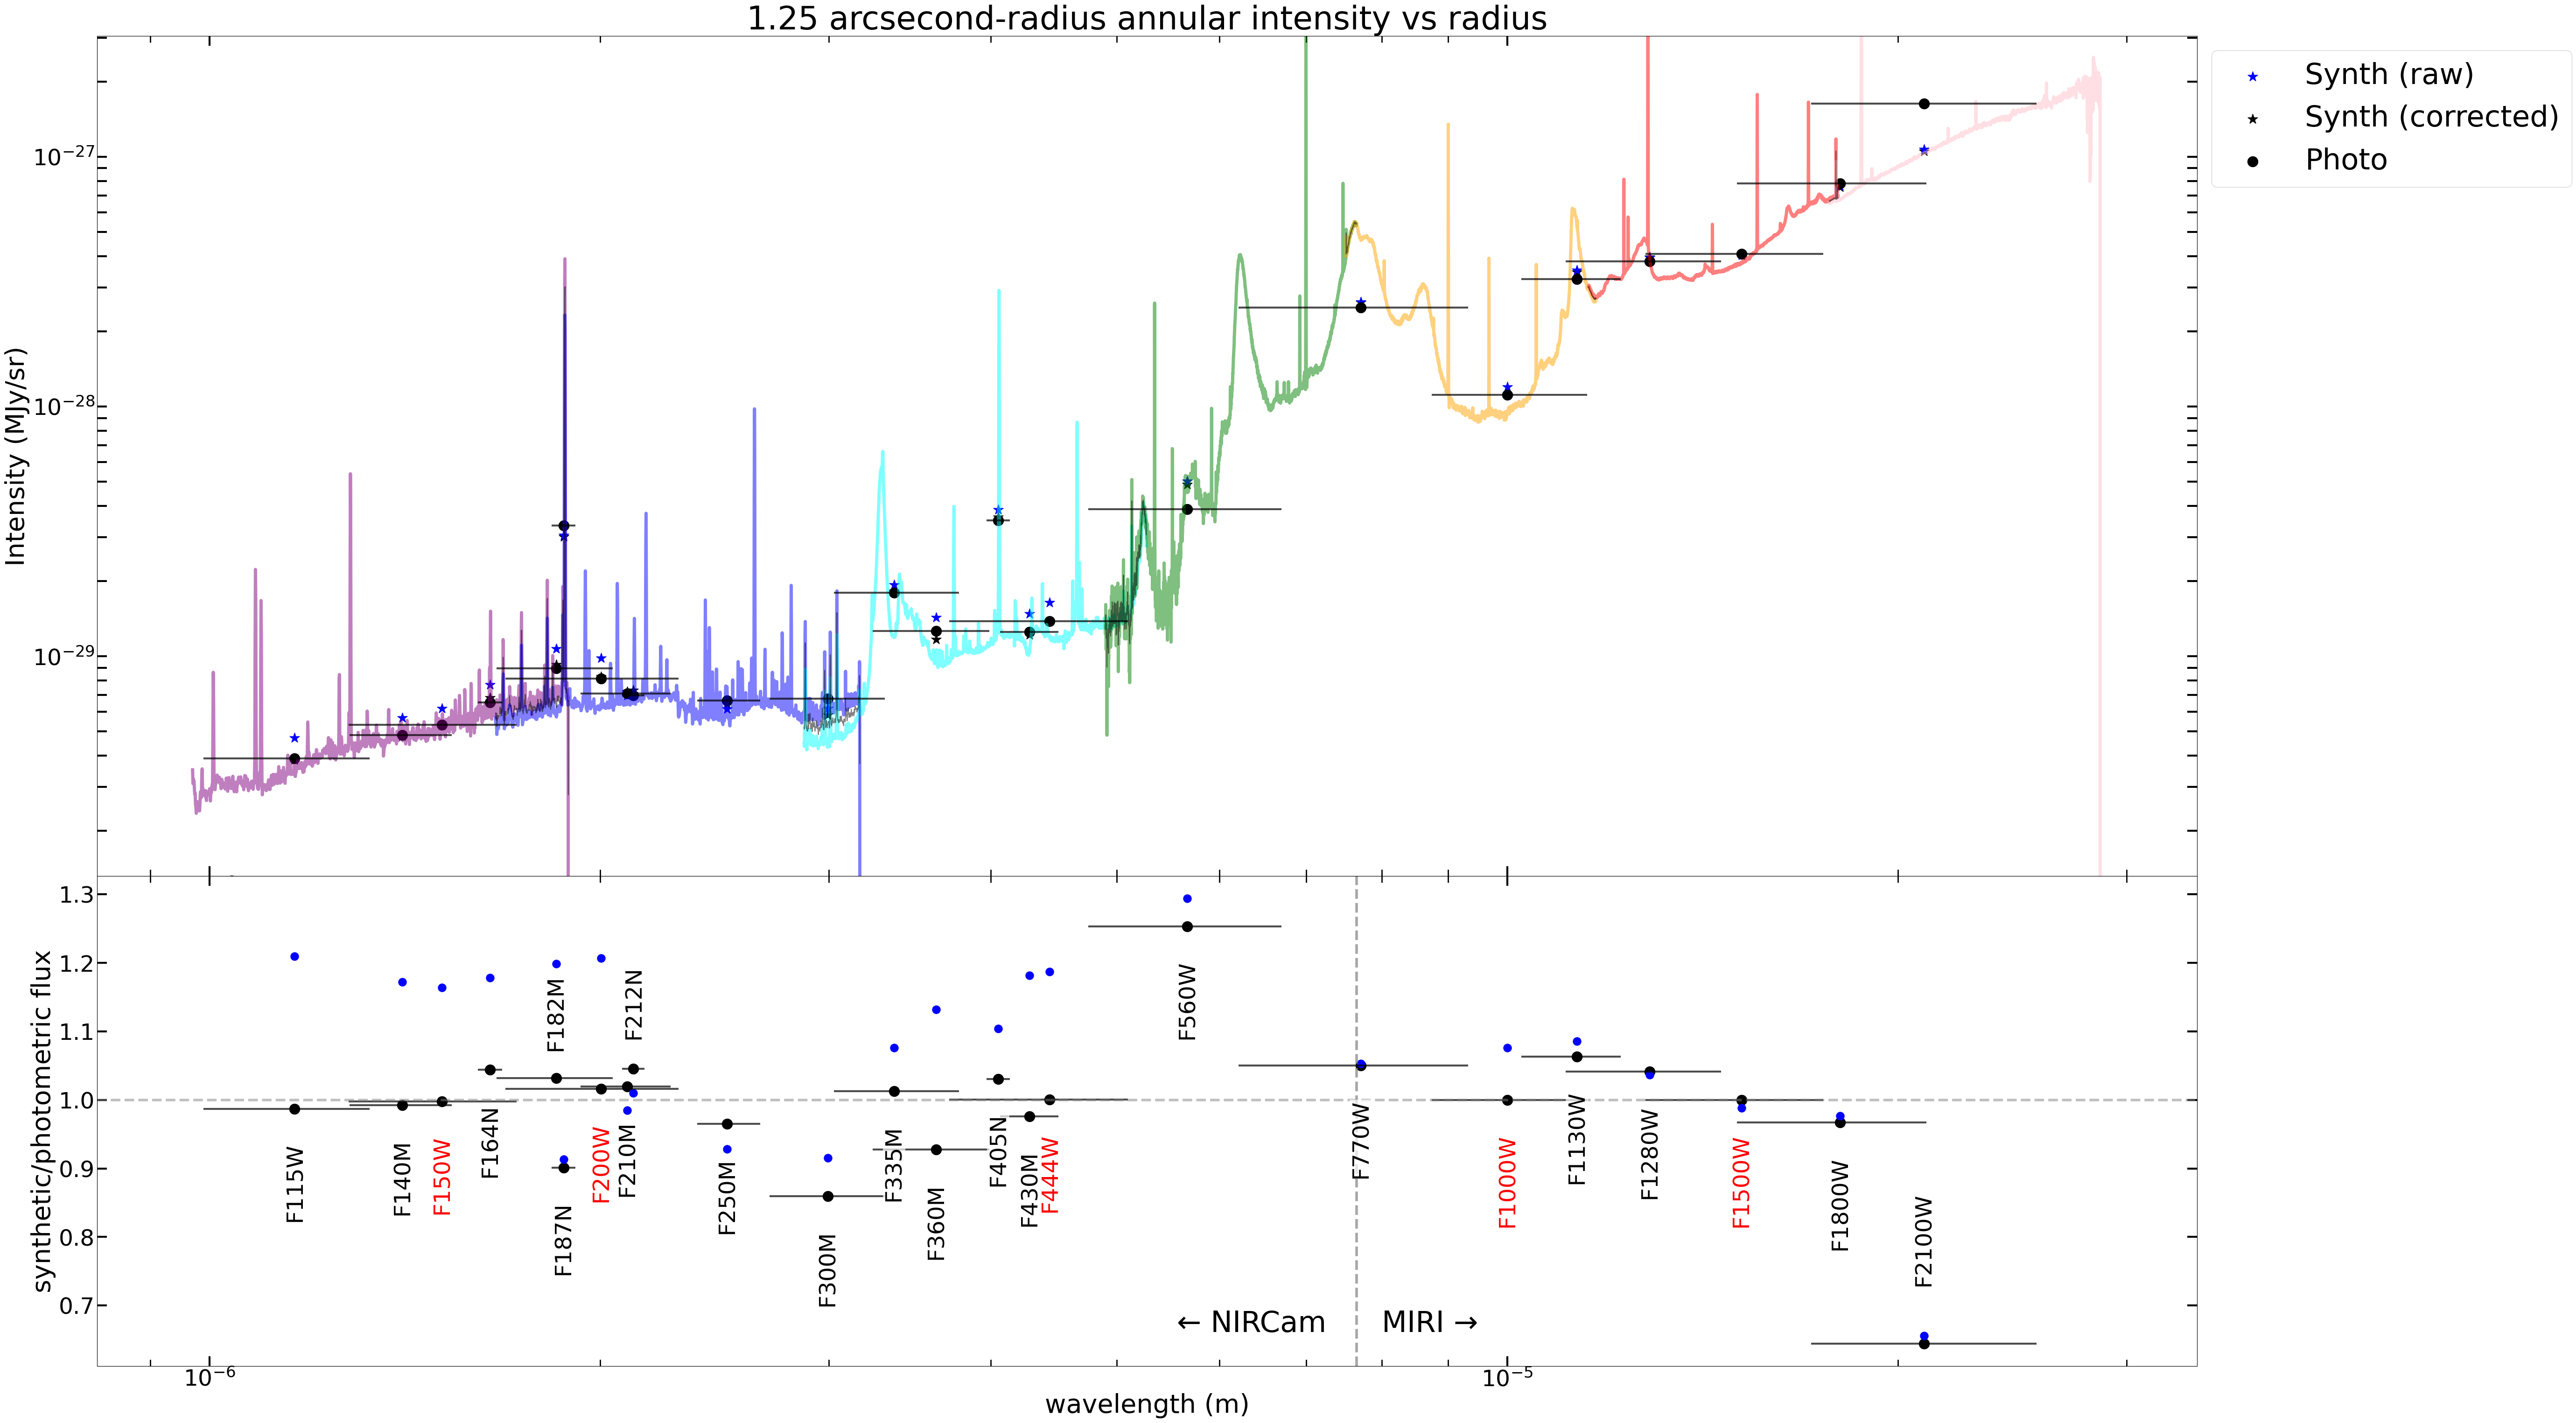

In [134]:
fig = plt.figure(figsize = (45,30))
ax_spec = fig.add_axes((0.05, 0.4, 1, 0.6))
ax_scat = fig.add_axes((0.05, 0.05, 1, 0.35))
fontsize_sm = 35
fontsize_lg = 45
marker_size = 250
cube_colors = ['purple', 'blue', 'cyan', 'green', 'orange', 'red', 'pink']
spec_y_min = 1 #TJ Flux should always be around 10^-20 so setting limits of 0-1 should never be too strict
spec_y_max = 0
short_bounds = []
long_bounds = []
for i, dataset in  enumerate(loc0_datasets):
        
        short_bounds.append(dataset['wavelength'][0])
        long_bounds.append(dataset['wavelength'][-1])
        ax_spec.plot(dataset['wavelength'], dataset['intensity'], alpha = 0.5, color = cube_colors[i], linewidth = 5)
        spec_y_min = min(spec_y_min, np.percentile(dataset['intensity'], 1)*0.5)
        spec_y_max = max(spec_y_max, np.percentile(dataset['intensity'], 98)*1.5)
        if i > 0:
            overlap_data = get_overlap_region(loc0_datasets[i-1], dataset)
            ax_spec.plot(overlap_data['wavelength'], overlap_data['intensity'], alpha = 0.5, color = 'black')

ax_spec.set_ylim(spec_y_min, spec_y_max)


#ax_spec.plot(data[0], data[1], linewidth = 1, color = 'black')

#ax_spec.plot(addresults0['wavelength'], addresults0['intensity'], linewidth = 5)
ax_scat.plot(addresults0['wavelength'], [1]*len(addresults0['intensity']), color = 'white', alpha = 0)
ax_spec.scatter(addresults0['mean_wl'], addresults0['synth_flux'], marker = '*', s=marker_size, color = 'black')
ax_spec.scatter(addresults0['mean_wl'], y_data*addresults0['photo_flux'], marker = '*', s=marker_size, color = 'blue')
ax_spec.scatter([], [], marker = '*', s=marker_size, color = 'blue', label = 'Synth (raw)')

ax_spec.scatter([], [], marker = '*', s=marker_size, color = 'black', label = 'Synth (corrected)')
ax_spec.scatter(addresults0['mean_wl'], addresults0['photo_flux'], marker = "o", s=marker_size, color = 'black')
ax_spec.scatter([], [], marker = "o", s=marker_size, color = 'black', label = 'Photo')
for i, filter in enumerate(filter_names):
    filter_short_wl, filter_long_wl = [x.value for x in get_filter_wl_range(filter)]
    ax_spec.hlines(y=addresults0['photo_flux'][i], xmin=filter_short_wl, xmax=filter_long_wl, color='black', alpha=0.7, linewidth=3)

ax_scat.scatter(addresults0['mean_wl'], addresults0['synth_flux']/addresults0['photo_flux'], s=marker_size, color = 'black')


ax_scat.tick_params(axis='x', which='minor', width=2, length=10, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_scat.tick_params(axis='x', which='major', width=3, length=15, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_scat.tick_params(axis='y', which='both', width=3, length=15, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_scat.set_xlabel('wavelength (m)', fontsize = 40)
ax_scat.set_ylabel('synthetic/photometric flux', fontsize = 40)
ax_spec.tick_params(axis='x', which='minor', width=2, length=10, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_spec.tick_params(axis='x', which='major', width=3, length=15, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_spec.tick_params(axis='y', which='both', width=3, length=15, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_spec.set_ylabel('Intensity (MJy/sr)', fontsize = 40)

ax_spec.set_title(f'1.25 arcsecond-radius annular intensity vs radius', fontsize = 50)

ax_scat.set_xscale('log')
ax_spec.set_xscale('log')
ax_spec.set_yscale('log')
label_positions = []  # to store display-space positions
w=0
for x, y, name in zip(addresults0['mean_wl'], addresults0['synth_flux']/addresults0['photo_flux'], addresults0['filter_name']):
    # initial offset (just below the point)
    filter_short_wl, filter_long_wl = [x.value for x in get_filter_wl_range(name)]
    ax_scat.hlines(y=y, xmin=filter_short_wl, xmax=filter_long_wl, color='black', alpha=0.7, linewidth=3)
    ax_scat.scatter(x, y_data[w], color = 'blue', s = 150)
    w +=1
    y_offset = -0.05 
    if name in anchor_filters:
        color = 'red'
    else:
        color = 'black'
    # convert data point to display coords
    x_disp, y_disp = ax_spec.transData.transform((x, y))
    
    # check overlap in display coordinates
    too_close = False
    for (xx, yy) in label_positions:
        if abs(x_disp - xx) < 20 and abs(y_disp + y_offset - yy) < 5:  
            # 20px horizontal & 12px vertical proximity → overlap
            too_close = True
            break
    
    # if overlapping, nudge upward instead of downward
    if too_close:
        y_offset = +0.2  
    if y < 0.8:
        y_offset = +0.22
    # save adjusted label display position
    label_positions.append((x_disp, y_disp + y_offset))
    if name == "F182M":
        y_offset = +0.15
    if name == 'F212N':
        y_offset = +0.15
    
    # actually plot text in data coordinates
    
    ax_scat.text(
        x, y + y_offset,
        name,
        ha="center", va="top",
        fontsize=fontsize_sm, rotation = 90, color = color,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.5)
    )

ymin, ymax = ax_scat.get_ylim()
text_y_pos = ymin * 1.1
ax_scat.axhline(y = 1, color = 'gray', linestyle = '--', linewidth = 4, alpha = 0.5)
ax_scat.axvline(x=7.650000025896587e-06, color='gray', linestyle='--', linewidth=4, alpha=0.7)
ax_scat.text(7.25e-6, text_y_pos, "← NIRCam", 
             ha='right', va='center', 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
             fontsize=fontsize_lg)

# Add MIRI label to the right
ax_scat.text(8e-6, text_y_pos, "MIRI →", 
         ha='left', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=fontsize_lg)
ax_spec.legend(loc = 'upper left', bbox_to_anchor=(1, 1), fontsize = fontsize_lg)
print(np.mean(addresults0['synth_flux']/addresults0['photo_flux']))
print(np.std(addresults0['synth_flux']/addresults0['photo_flux']))


0.9927445963166761
0.10046749112877129


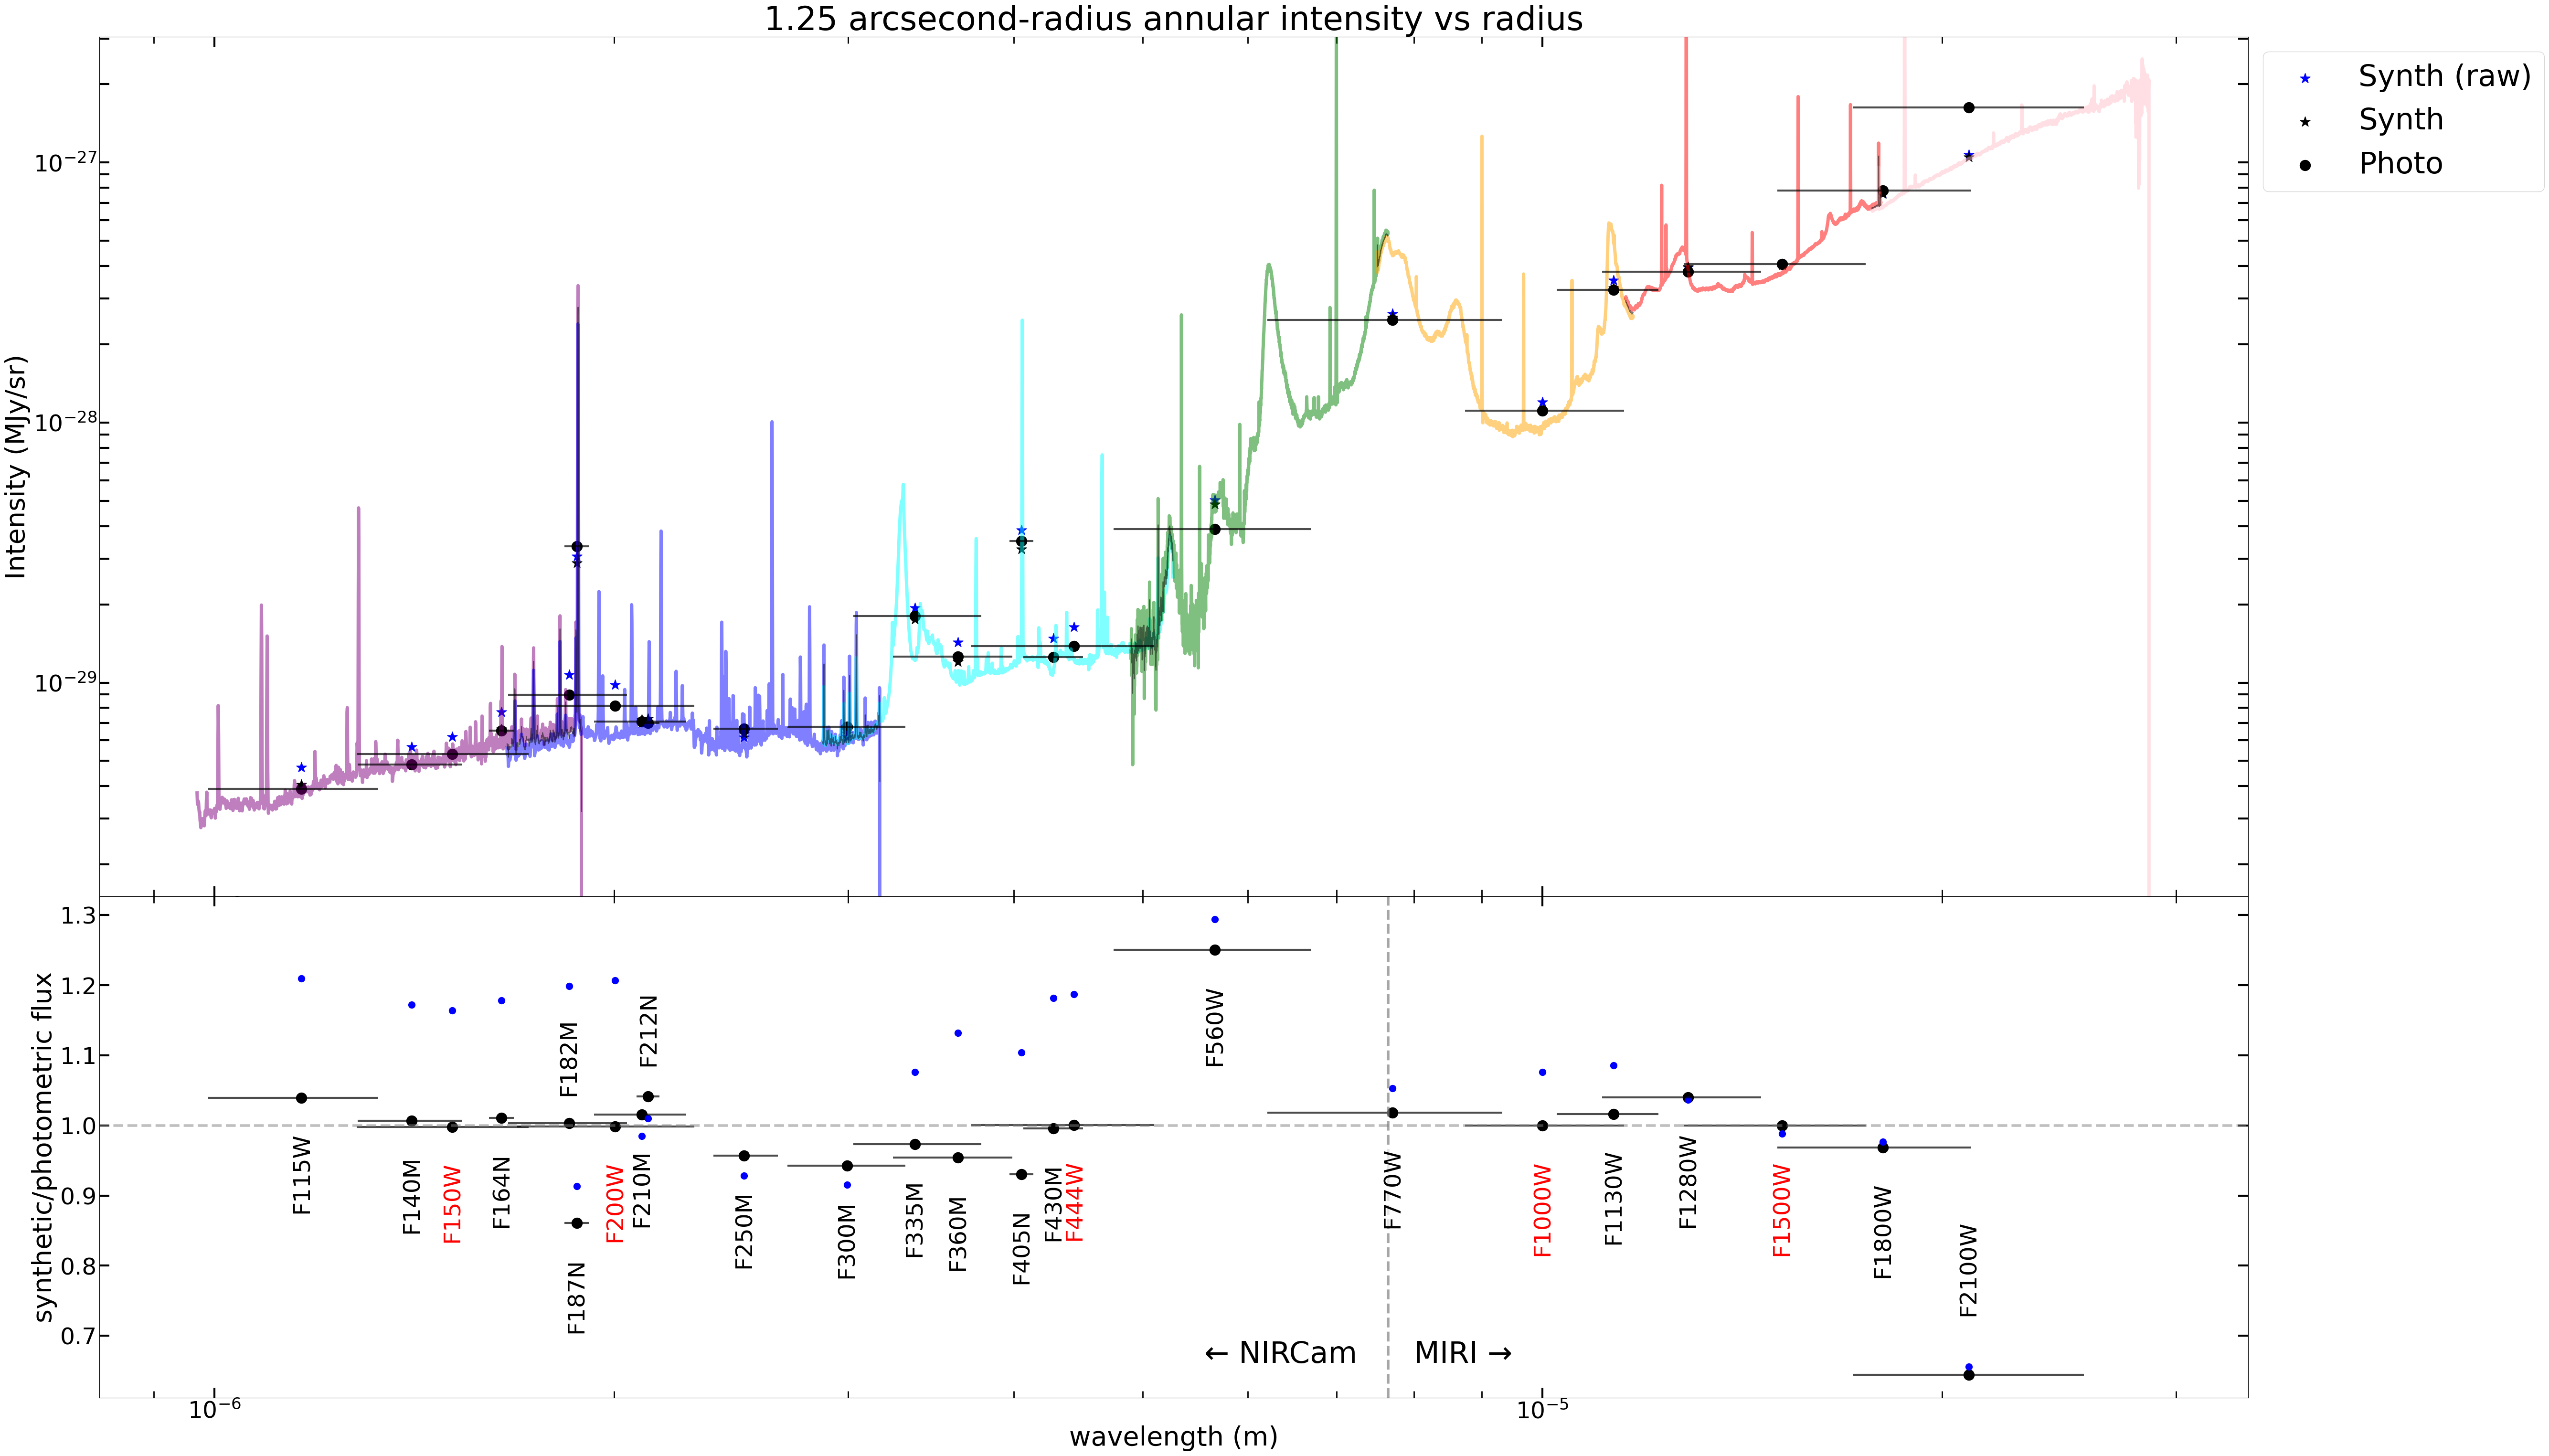

In [135]:
fig = plt.figure(figsize = (45,30))
ax_spec = fig.add_axes((0.05, 0.4, 1, 0.6))
ax_scat = fig.add_axes((0.05, 0.05, 1, 0.35))
fontsize_sm = 35
fontsize_lg = 45
marker_size = 250
cube_colors = ['purple', 'blue', 'cyan', 'green', 'orange', 'red', 'pink']
spec_y_min = 1 #TJ Flux should always be around 10^-20 so setting limits of 0-1 should never be too strict
spec_y_max = 0
short_bounds = []
long_bounds = []
for i, dataset in  enumerate(loc0_m_datasets):
        
        short_bounds.append(dataset['wavelength'][0])
        long_bounds.append(dataset['wavelength'][-1])
        ax_spec.plot(dataset['wavelength'], dataset['intensity'], alpha = 0.5, color = cube_colors[i], linewidth = 5)
        spec_y_min = min(spec_y_min, np.percentile(dataset['intensity'], 1)*0.5)
        spec_y_max = max(spec_y_max, np.percentile(dataset['intensity'], 98)*1.5)
        if i > 0:
            overlap_data = get_overlap_region(loc0_m_datasets[i-1], dataset)
            ax_spec.plot(overlap_data['wavelength'], overlap_data['intensity'], alpha = 0.5, color = 'black')

ax_spec.set_ylim(spec_y_min, spec_y_max)
ax_spec.scatter(addresults0['mean_wl'], y_data*multresults0['photo_flux'], marker = '*', s=marker_size, color = 'blue')
ax_spec.scatter([], [], marker = '*', s=marker_size, color = 'blue', label = 'Synth (raw)')

#ax_spec.plot(multresults0['wavelength'], multresults0['intensity'], linewidth = 5)
ax_scat.plot(multresults0['wavelength'], [1]*len(multresults0['intensity']), color = 'white', alpha = 0)
ax_spec.scatter(multresults0['mean_wl'], multresults0['synth_flux'], marker = '*', s=marker_size, color = 'black')
ax_spec.scatter([], [], marker = '*', s=marker_size, color = 'black', label = 'Synth')
ax_spec.scatter(multresults0['mean_wl'], multresults0['photo_flux'], marker = "o", s=marker_size, color = 'black')
ax_spec.scatter([], [], marker = "o", s=marker_size, color = 'black', label = 'Photo')
for i, filter in enumerate(filter_names):
    filter_short_wl, filter_long_wl = [x.value for x in get_filter_wl_range(filter)]
    ax_spec.hlines(y=multresults0['photo_flux'][i], xmin=filter_short_wl, xmax=filter_long_wl, color='black', alpha=0.7, linewidth=3)

ax_scat.scatter(multresults0['mean_wl'], multresults0['synth_flux']/multresults0['photo_flux'], s=marker_size, color = 'black')


ax_scat.tick_params(axis='x', which='minor', width=2, length=10, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_scat.tick_params(axis='x', which='major', width=3, length=15, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_scat.tick_params(axis='y', which='both', width=3, length=15, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_scat.set_xlabel('wavelength (m)', fontsize = 40)
ax_scat.set_ylabel('synthetic/photometric flux', fontsize = 40)
ax_spec.tick_params(axis='x', which='minor', width=2, length=10, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_spec.tick_params(axis='x', which='major', width=3, length=15, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_spec.tick_params(axis='y', which='both', width=3, length=15, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_spec.set_ylabel('Intensity (MJy/sr)', fontsize = 40)

ax_spec.set_title(f'1.25 arcsecond-radius annular intensity vs radius', fontsize = 50)

ax_scat.set_xscale('log')
ax_spec.set_xscale('log')
ax_spec.set_yscale('log')
label_positions = []  # to store display-space positions
w=0
for x, y, name in zip(multresults0['mean_wl'], multresults0['synth_flux']/multresults0['photo_flux'], addresults0['filter_name']):
    # initial offset (just below the point)
    filter_short_wl, filter_long_wl = [x.value for x in get_filter_wl_range(name)]
    ax_scat.hlines(y=y, xmin=filter_short_wl, xmax=filter_long_wl, color='black', alpha=0.7, linewidth=3)
    ax_scat.scatter(x, y_data[w], color = 'blue', marker = 'o', s = 100)
    w+=1
    y_offset = -0.05 
    if name in anchor_filters:
        color = 'red'
    else:
        color = 'black'
    # convert data point to display coords
    x_disp, y_disp = ax_spec.transData.transform((x, y))
    
    # check overlap in display coordinates
    too_close = False
    for (xx, yy) in label_positions:
        if abs(x_disp - xx) < 20 and abs(y_disp + y_offset - yy) < 5:  
            # 20px horizontal & 12px vertical proximity → overlap
            too_close = True
            break
    
    # if overlapping, nudge upward instead of downward
    if too_close:
        y_offset = +0.2  
    if y < 0.8:
        y_offset = +0.22
    # save adjusted label display position
    label_positions.append((x_disp, y_disp + y_offset))
    if name == "F182M":
        y_offset = +0.15
    if name == 'F212N':
        y_offset = +0.15
    # actually plot text in data coordinates
    
    ax_scat.text(
        x, y + y_offset,
        name,
        ha="center", va="top",
        fontsize=fontsize_sm, rotation = 90, color = color,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.5)
    )

ymin, ymax = ax_scat.get_ylim()
text_y_pos = ymin * 1.1
ax_scat.axhline(y = 1, color = 'gray', linestyle = '--', linewidth = 4, alpha = 0.5)
ax_scat.axvline(x=7.650000025896587e-06, color='gray', linestyle='--', linewidth=4, alpha=0.7)
ax_scat.text(7.25e-6, text_y_pos, "← NIRCam", 
             ha='right', va='center', 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
             fontsize=fontsize_lg)

# Add MIRI label to the right
ax_scat.text(8e-6, text_y_pos, "MIRI →", 
         ha='left', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=fontsize_lg)
ax_spec.legend(loc = 'upper left', bbox_to_anchor=(1, 1), fontsize = fontsize_lg)
print(np.mean(addresults0['synth_flux']/addresults0['photo_flux']))
print(np.std(addresults0['synth_flux']/addresults0['photo_flux']))


0.9927445963166761
0.10046749112877129


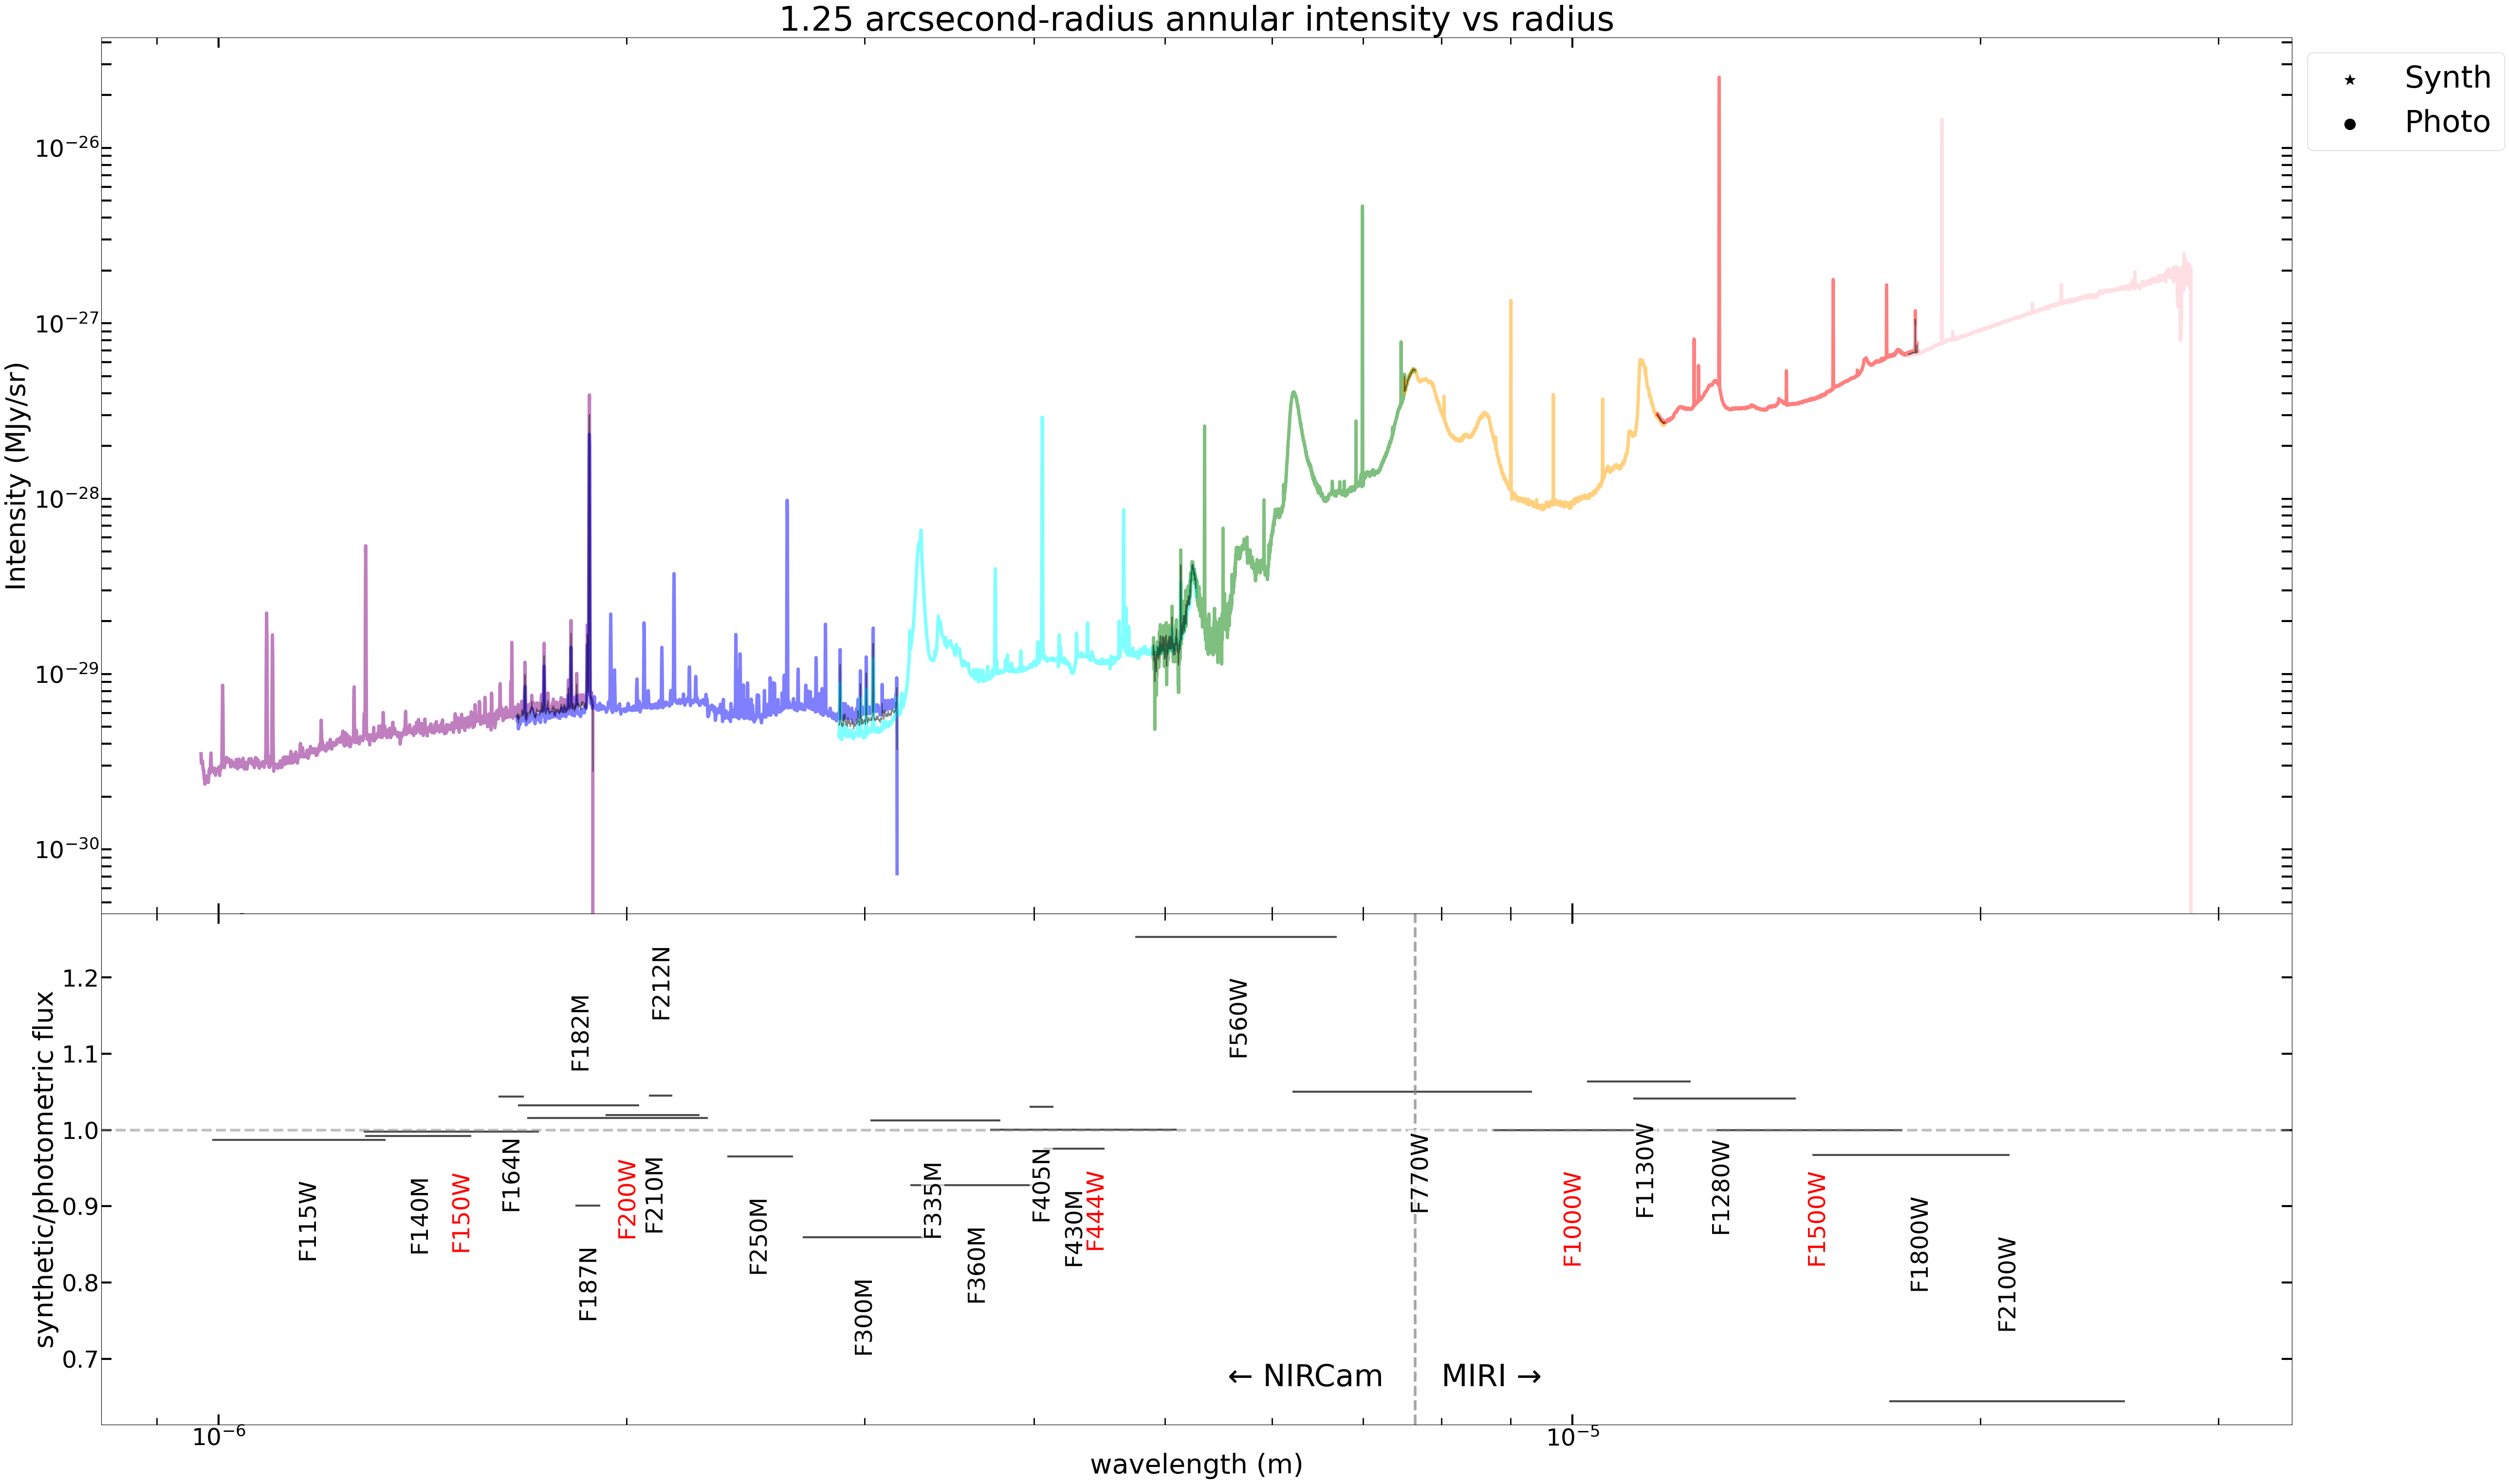

In [100]:
fig = plt.figure(figsize = (45,30))
ax_spec = fig.add_axes((0.05, 0.4, 1, 0.6))
ax_scat = fig.add_axes((0.05, 0.05, 1, 0.35))
fontsize_sm = 35
fontsize_lg = 45
marker_size = 250
cube_colors = ['purple', 'blue', 'cyan', 'green', 'orange', 'red', 'pink']
spec_y_min = 1 #TJ Flux should always be around 10^-20 so setting limits of 0-1 should never be too strict
spec_y_max = 0
short_bounds = []
long_bounds = []
for i, dataset in  enumerate(loc0_datasets):
        
        short_bounds.append(dataset['wavelength'][0])
        long_bounds.append(dataset['wavelength'][-1])
        ax_spec.plot(dataset['wavelength'], dataset['intensity'], alpha = 0.5, color = cube_colors[i], linewidth = 5)
        spec_y_min = min(spec_y_min, np.percentile(dataset['intensity'], 1)*0.5)
        spec_y_max = max(spec_y_max, np.percentile(dataset['intensity'], 98)*1.5)
        if i > 0:
            overlap_data = get_overlap_region(loc0_datasets[i-1], dataset)
            ax_spec.plot(overlap_data['wavelength'], overlap_data['intensity'], alpha = 0.5, color = 'black')



ax_spec.plot(addresults0['wavelength'], addresults0['intensity'], linewidth = 5)
ax_scat.plot(addresults0['wavelength'], [1]*len(addresults0['intensity']), color = 'white', alpha = 0)
ax_spec.scatter(addresults0['mean_wl'], addresults0['synth_flux'], marker = '*', s=marker_size, color = 'black')
ax_spec.scatter([], [], marker = '*', s=marker_size, color = 'black', label = 'Synth')
ax_spec.scatter(addresults0['mean_wl'], addresults0['photo_flux'], marker = "o", s=marker_size, color = 'black')
ax_spec.scatter([], [], marker = "o", s=marker_size, color = 'black', label = 'Photo')
for i, filter in enumerate(filter_names):
    filter_short_wl, filter_long_wl = [x.value for x in get_filter_wl_range(filter)]
    ax_spec.hlines(y=addresults0['photo_flux'][i], xmin=filter_short_wl, xmax=filter_long_wl, color='black', alpha=0.7, linewidth=3)

#ax_scat.scatter(addresults0['mean_wl'], addresults0['synth_flux']/addresults0['photo_flux'], s=marker_size, color = 'black')


ax_scat.tick_params(axis='x', which='minor', width=2, length=10, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_scat.tick_params(axis='x', which='major', width=3, length=15, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_scat.tick_params(axis='y', which='both', width=3, length=15, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_scat.set_xlabel('wavelength (m)', fontsize = 40)
ax_scat.set_ylabel('synthetic/photometric flux', fontsize = 40)
ax_spec.tick_params(axis='x', which='minor', width=2, length=10, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_spec.tick_params(axis='x', which='major', width=3, length=15, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_spec.tick_params(axis='y', which='both', width=3, length=15, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_spec.set_ylabel('Intensity (MJy/sr)', fontsize = 40)

ax_spec.set_title(f'1.25 arcsecond-radius annular intensity vs radius', fontsize = 50)

ax_scat.set_xscale('log')
ax_spec.set_xscale('log')
ax_spec.set_yscale('log')
label_positions = []  # to store display-space positions

for x, y, name in zip(addresults0['mean_wl'], addresults0['synth_flux']/addresults0['photo_flux'], addresults0['filter_name']):
    # initial offset (just below the point)
    filter_short_wl, filter_long_wl = [x.value for x in get_filter_wl_range(name)]
    ax_scat.hlines(y=y, xmin=filter_short_wl, xmax=filter_long_wl, color='black', alpha=0.7, linewidth=3)
    y_offset = -0.05 
    if name in anchor_filters:
        color = 'red'
    else:
        color = 'black'
    # convert data point to display coords
    x_disp, y_disp = ax_spec.transData.transform((x, y))
    
    # check overlap in display coordinates
    too_close = False
    for (xx, yy) in label_positions:
        if abs(x_disp - xx) < 20 and abs(y_disp + y_offset - yy) < 5:  
            # 20px horizontal & 12px vertical proximity → overlap
            too_close = True
            break
    
    # if overlapping, nudge upward instead of downward
    if too_close:
        y_offset = +0.2  
    if y < 0.8:
        y_offset = +0.22
    # save adjusted label display position
    label_positions.append((x_disp, y_disp + y_offset))
    if name == "F182M":
        y_offset = +0.15
    
    # actually plot text in data coordinates
    
    ax_scat.text(
        x, y + y_offset,
        name,
        ha="center", va="top",
        fontsize=fontsize_sm, rotation = 90, color = color,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.5)
    )

ymin, ymax = ax_scat.get_ylim()
text_y_pos = ymin * 1.1
ax_scat.axhline(y = 1, color = 'gray', linestyle = '--', linewidth = 4, alpha = 0.5)
ax_scat.axvline(x=7.650000025896587e-06, color='gray', linestyle='--', linewidth=4, alpha=0.7)
ax_scat.text(7.25e-6, text_y_pos, "← NIRCam", 
             ha='right', va='center', 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
             fontsize=fontsize_lg)

# Add MIRI label to the right
ax_scat.text(8e-6, text_y_pos, "MIRI →", 
         ha='left', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=fontsize_lg)
ax_spec.legend(loc = 'upper left', bbox_to_anchor=(1, 1), fontsize = fontsize_lg)
print(np.mean(addresults0['synth_flux']/addresults0['photo_flux']))
print(np.std(addresults0['synth_flux']/addresults0['photo_flux']))


In [ ]:
fig = plt.figure(figsize=(12, 10))
ax_spec = fig.add_axes((0.05, 0.4, 1, 0.6))
ax_scat = fig.add_axes((0.05, 0.05, 1, 0.35))
loc = locations[0]

for ifu_file in full_raw_ifu_files_loc0[:2]:
    filter_name = get_largest_filter_within(ifu_file)
    image_file = [x for x in v0p3_images if extract_filter_name(x)==filter_name][0]
    raw_data = get_IFU_spectrum(ifu_file, loc, radius, replace_negatives = False)
    dataset = adjust_spectrum(ifu_file, filter_name, v0p3_images, loc, radius, adjustment_operation = 'add')
    filter_wl, filter_trans = get_filter_data(filter_name)
    synth = get_Fnu_transmission(dataset['intensity'], dataset['wavelength'], filter_trans, filter_wl, warnings = True)
    photo = get_image_flux(image_file, loc, radius, replace_negatives = False)
    
    
    
    ax_spec.plot(raw_data['wavelength'], raw_data['intensity'], color = 'red', alpha = 0.5)
    ax_spec.plot(dataset['wavelength'], dataset['intensity'], color = 'green', alpha = 0.5)
    ax_spec.set_xscale('log')
    ax_spec.set_yscale('log')
    for filter_file in filter_files:
        
        filter_name = extract_filter_name(filter_file)
        if is_filter_relevent(filter_name, ifu_file):
            filter_mean = jwst_means[filter_name].value
            image_file = [x for x in v0p3_images if extract_filter_name(x)==filter_name][0]
            photo_flux =  get_image_flux(image_file, loc, radius, replace_negatives = False)
            filter_wl, filter_trans = get_filter_data(filter_name)
            
            synth_flux = get_Fnu_transmission(dataset['intensity'], dataset['wavelength'], filter_trans, filter_wl, warnings = True)
            ax_spec.scatter(filter_mean, photo_flux, marker = "*", s =25, color = 'blue')
            ax_spec.scatter(filter_mean, synth_flux, marker = "*", s = 10, color = 'black')
            ax_scat.scatter(filter_mean, (synth_flux/photo_flux))
plt.show()



In [ ]:
dataset1

A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs


TypeError: adjust_spectrum() got an unexpected keyword argument 'retry'

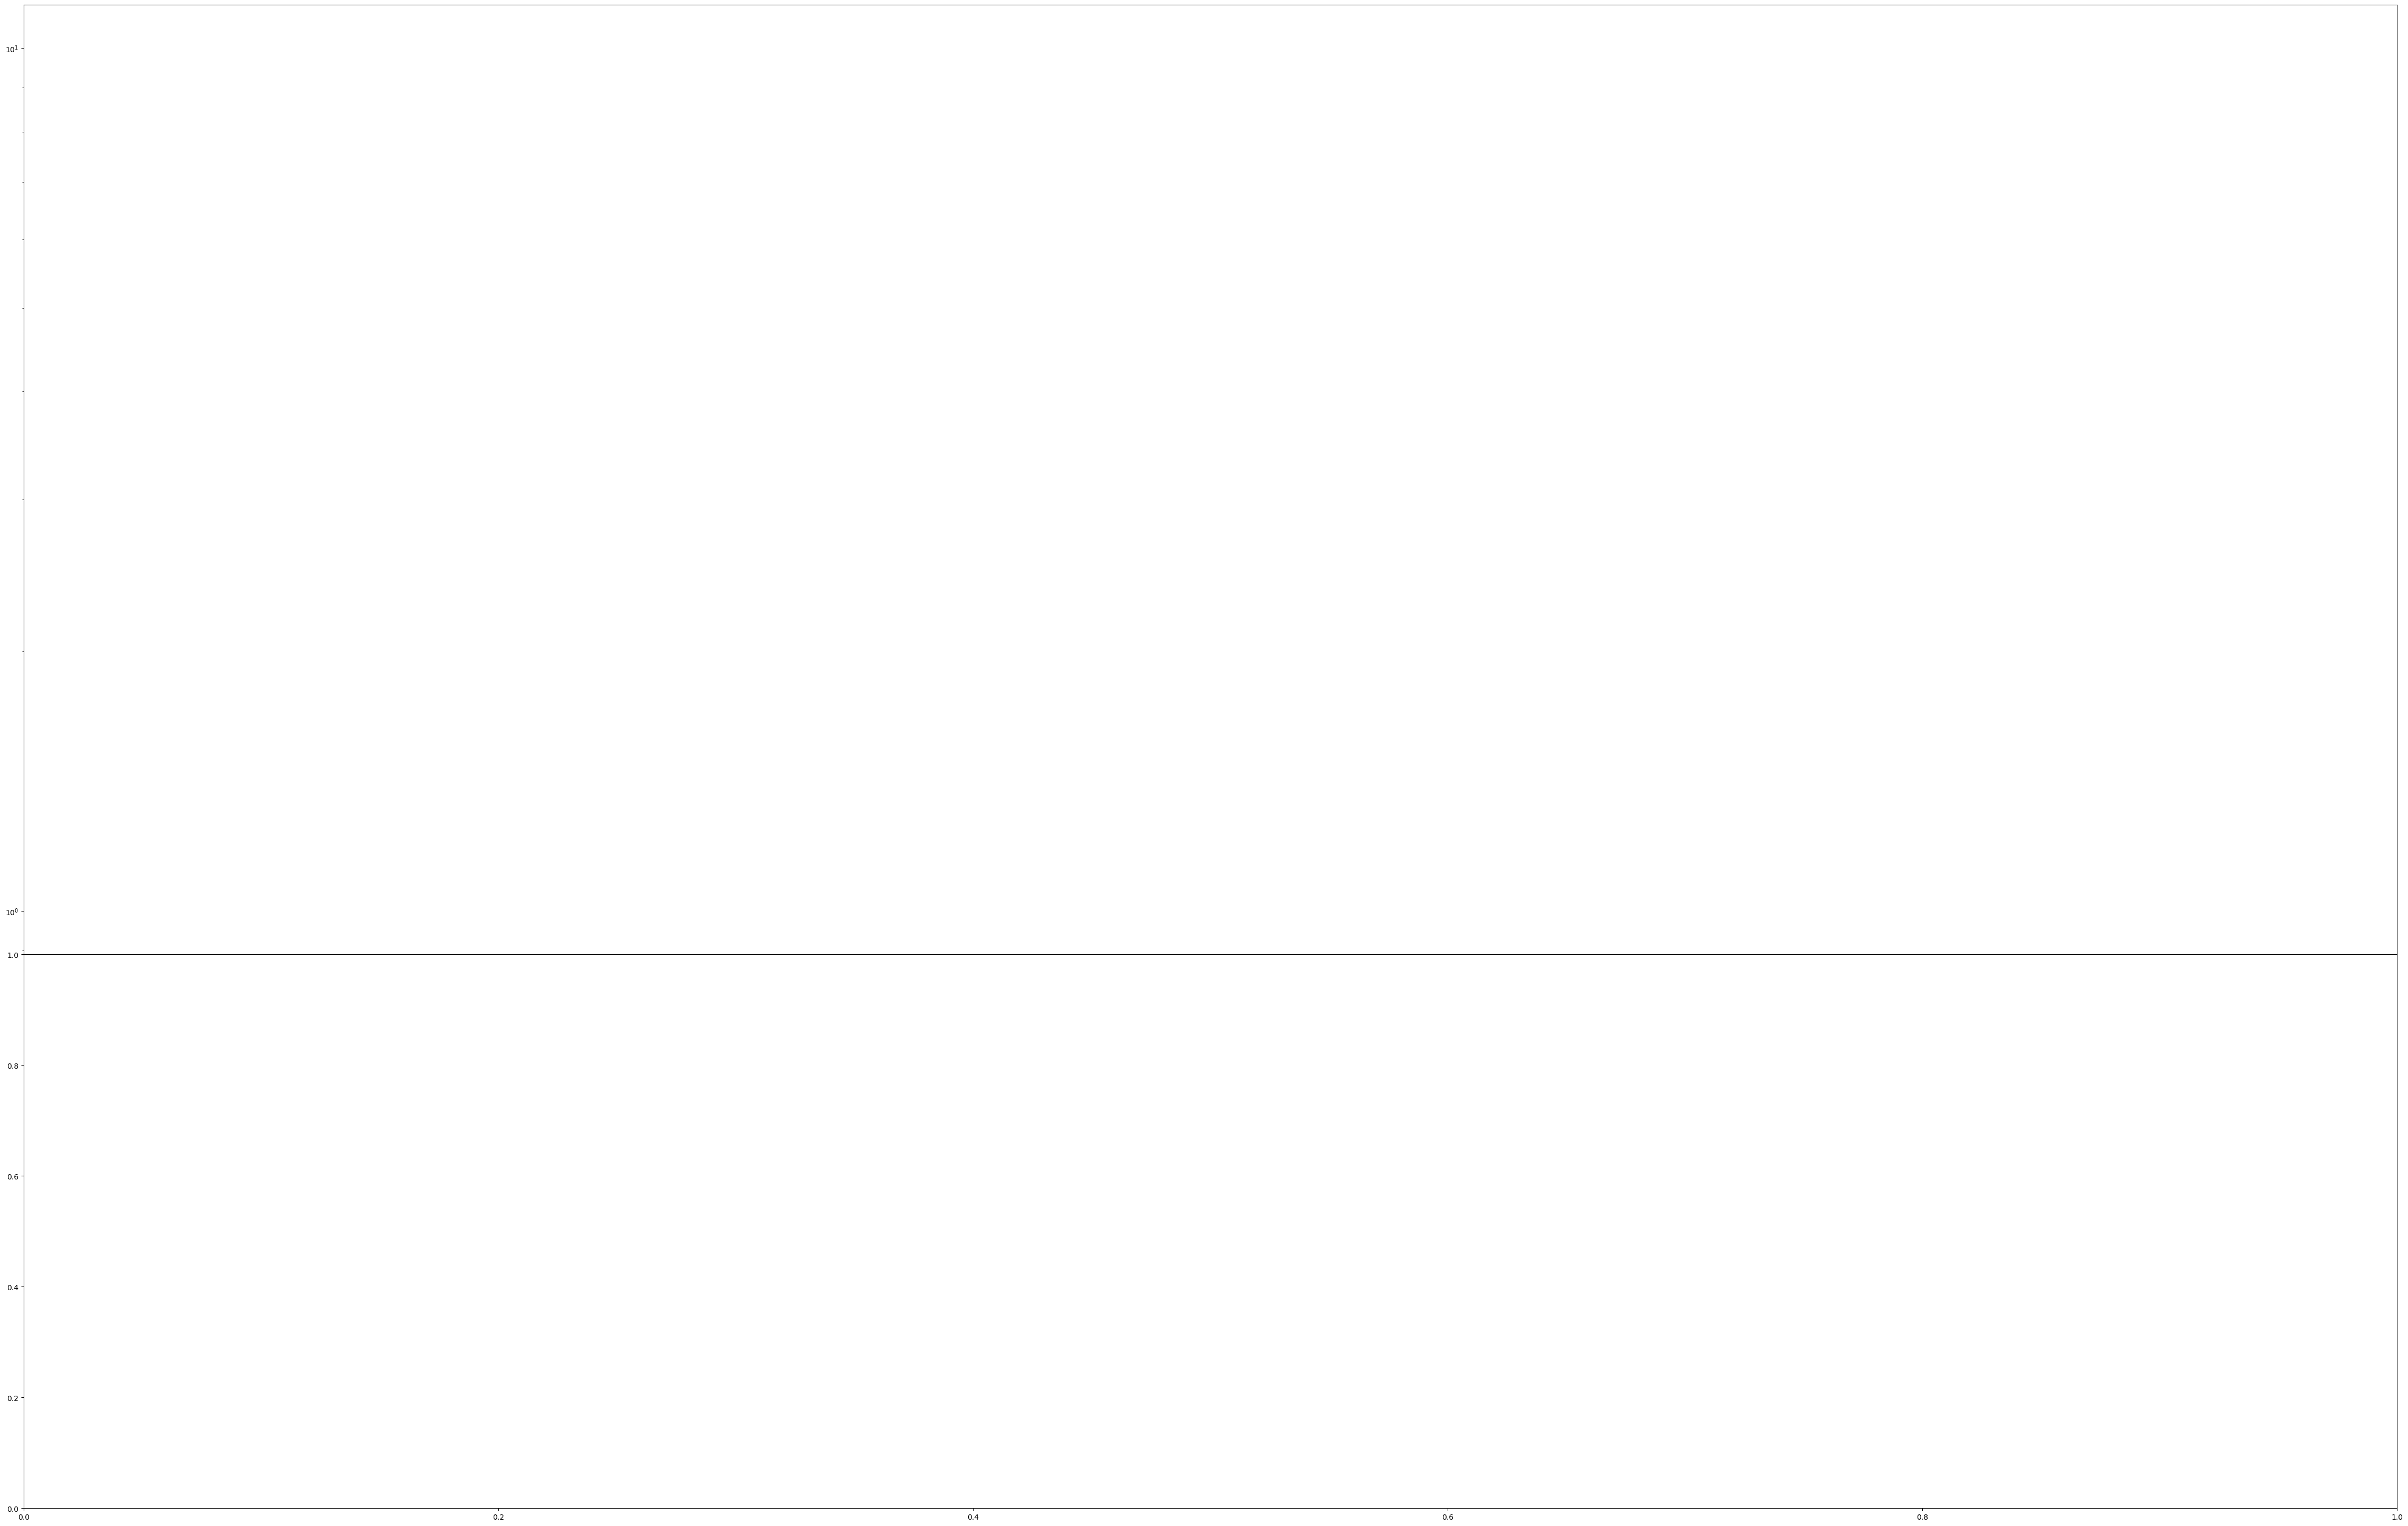

In [89]:


            
filters = [extract_filter_name(x) for x in filter_files if full_coverage(extract_filter_name(x),full_raw_ifu_files_loc0[0])=="good"]


loc = locations[0]
ifu_file = full_raw_ifu_files_loc0[0]
fig = plt.figure(figsize = (45,30))
ax_spec = fig.add_axes((0.05, 0.4, 1, 0.6))
ax_scatter = fig.add_axes((0.05, 0.05, 1, 0.35))
ax_spec.set_yscale('log')
ax_spec.set_xscale('log')
for filter_name in filters:
    image_file = [x for x in image_files if extract_filter_name(x)==filter_name][0]
    raw_data = get_IFU_spectrum(ifu_file, loc, radius, replace_negatives = False)
    dataset = adjust_spectrum(ifu_file, filter_name, loc, radius, adjustment_operation = 'add', retry = False)
    filter_wl, filter_trans = get_filter_data(filter_name)
    synth = get_Fnu_transmission(dataset['intensity'], dataset['wavelength'], filter_trans, filter_wl, warnings = True)
    photo = get_image_flux(image_file, loc, radius, replace_negatives = False)
    ax_spec.plot(raw_data['wavelength'], raw_data['intensity'], alpha = 0.5, color = 'red')
    ax_spec.plot(dataset['wavelength'], dataset['intensity'], alpha = 0.5, color = 'green')
    for filter_file in filter_files[:4]:
        filter_name = extract_filter_name(filter_file)
        filter_mean = jwst_means[filter_name].value
        image_file = [x for x in image_files if extract_filter_name(x)==filter_name][0]
        photo_flux =  get_image_flux(image_file, loc, radius, replace_negatives = False)
        filter_wl, filter_trans = get_filter_data(filter_name)
        synth_flux = get_Fnu_transmission(dataset['intensity'], dataset['wavelength'], filter_trans, filter_wl, warnings = True)
        plt.scatter(filter_mean, photo_flux, marker = "*", s =25, color = 'blue')
        plt.scatter(filter_mean, synth_flux, marker = "*", s = 10, color = 'black')
    plt.show()

In [ ]:
for i, file in enumerate(full_raw_ifu_files_loc0):
    print(i, get_largest_filter_within(file))

In [ ]:
files = glob.glob('Data_files/IFU_files/calibrated_IFUs/location_2/*')
colors = ['purple', 'blue', 'cyan', 'green', 'orange', 'red', 'pink']
for i, file in enumerate(files):
    data = np.load(file)
    plt.loglog(data['wavelength'], data['intensity'], color = colors[i])
plt.show()

files = glob.glob('Data_files/IFU_files/calibrated_IFUs/location_3/*')
colors = ['purple', 'blue', 'cyan', 'green', 'orange', 'red', 'pink']
for i, file in enumerate(files):
    data = np.load(file)
    plt.loglog(data['wavelength'], data['intensity'], color = colors[i])
plt.show()

In [53]:
import subprocess
import time
from datetime import datetime

def check_internet():
    # Try pinging Google's DNS with one packet
    try:
        result = subprocess.run(
            ["ping", "-c", "1", "-W", "1", "8.8.8.8"],  # "-W 1" timeout = 1s
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL
        )
        return result.returncode == 0
    except Exception:
        return False

print("Monitoring internet connectivity every second... (stop cell to end)")
while True:
    connected = check_internet()
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    if connected:
        print(f"{timestamp}  CONNECTED")
    else:
        print(f"{timestamp}  *** DISCONNECTED ***")
    time.sleep(1)


Monitoring internet connectivity every second... (stop cell to end)
2025-11-19 11:27:17  CONNECTED
2025-11-19 11:27:18  CONNECTED
2025-11-19 11:27:19  CONNECTED
2025-11-19 11:27:20  CONNECTED
2025-11-19 11:27:21  CONNECTED
2025-11-19 11:27:22  CONNECTED
2025-11-19 11:27:23  CONNECTED
2025-11-19 11:27:24  CONNECTED
2025-11-19 11:27:25  CONNECTED
2025-11-19 11:27:26  CONNECTED
2025-11-19 11:27:27  CONNECTED
2025-11-19 11:27:28  CONNECTED
2025-11-19 11:27:29  CONNECTED
2025-11-19 11:27:30  CONNECTED
2025-11-19 11:27:31  CONNECTED
2025-11-19 11:27:32  CONNECTED
2025-11-19 11:27:33  CONNECTED
2025-11-19 11:27:34  CONNECTED
2025-11-19 11:27:35  CONNECTED
2025-11-19 11:27:36  CONNECTED
2025-11-19 11:27:37  CONNECTED
2025-11-19 11:27:38  CONNECTED
2025-11-19 11:27:39  CONNECTED
2025-11-19 11:27:40  CONNECTED
2025-11-19 11:27:41  CONNECTED
2025-11-19 11:27:42  CONNECTED
2025-11-19 11:27:43  CONNECTED
2025-11-19 11:27:44  CONNECTED
2025-11-19 11:27:45  CONNECTED
2025-11-19 11:27:46  CONNECTED
20

KeyboardInterrupt: 

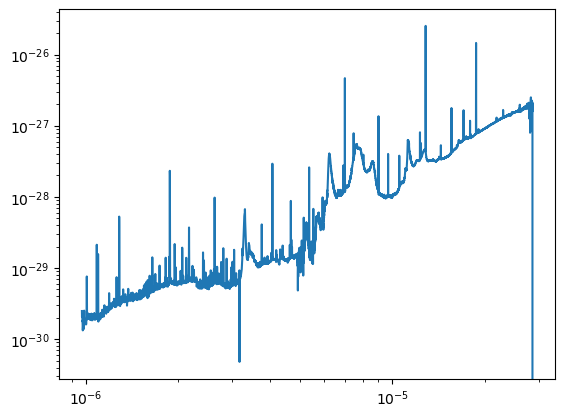

In [106]:
plt.loglog(data[0],data[1])

array([[9.70318029e-07, 9.70954029e-07, 9.71590029e-07, ...,
        2.86890009e-05, 2.86950009e-05, 2.87010009e-05],
       [2.48870648e-30, 2.07079676e-30, 2.20993411e-30, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])